# Graduate Statistics Analysis in Canada
## A Comprehensive Analysis Following CRISP-DM Framework

This notebook analyzes graduate statistics in Canada using the CRISP-DM framework. It includes data exploration, machine learning modeling, and time series analysis.

## 1. Import Required Libraries

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# Model persistence
import joblib

# Set style for plotting
#plt.style.use('seaborn')
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Define Utility Functions

Here we define all the helper functions that will be used throughout the analysis.

In [15]:
def load_and_inspect_data(file_path):
    """Load data and perform initial inspection.

    Args:
        file_path (str): Path to the dataset file

    Returns:
        pd.DataFrame: Loaded dataset
    """
    df = pd.read_csv(file_path)
    print("Dataset Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())
    return df

def clean_data(df):
    """Clean and preprocess the data.

    Args:
        df (pd.DataFrame): Raw dataframe

    Returns:
        pd.DataFrame: Cleaned dataframe
    """
    df_clean = df.copy()

    # Handle missing values
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns

    df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].mean())
    df_clean[categorical_cols] = df_clean[categorical_cols].fillna(df_clean[categorical_cols].mode().iloc[0])

    # Remove duplicates
    df_clean = df_clean.drop_duplicates()

    return df_clean

def plot_distributions_one_by_one(df, columns):
    """Plot distributions of specified columns one by one.

    Args:
        df (pd.DataFrame): Input dataframe
        columns (list): List of columns to plot
    """
    for col in columns:
        plt.figure(figsize=(12, 6))  # Set size for each plot
        if df[col].dtype in ['int64', 'float64']:
            sns.histplot(data=df, x=col)
        else:
            sns.countplot(data=df, x=col)

        plt.title(f'Distribution of {col}', fontsize=14)
        plt.xticks(rotation=90)  # Rotate x-axis labels for readability
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()  # Display the plot


def perform_time_series_analysis(df, date_col, value_col):
    """Perform time series analysis on specified columns.

    Args:
        df (pd.DataFrame): Input dataframe
        date_col (str): Name of date column
        value_col (str): Name of value column to analyze
    """
    # Convert to time series
    ts = df.set_index(date_col)[value_col]

    # Decompose series
    decomposition = seasonal_decompose(ts, period=12)

    # Plot components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.show()

def perform_clustering(df, columns, n_clusters=3):
    """Perform clustering analysis on specified columns.

    Args:
        df (pd.DataFrame): Input dataframe
        columns (list): Columns to use for clustering
        n_clusters (int): Number of clusters

    Returns:
        array: Cluster labels
    """
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df[columns])

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)

    # Plot results
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Clusters Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

    return clusters

def train_evaluate_model(X_train, X_test, y_train, y_test, model, params_grid):
    """Train and evaluate a machine learning model.

    Args:
        X_train, X_test, y_train, y_test: Train and test datasets
        model: Model instance
        params_grid (dict): Parameters grid for GridSearchCV

    Returns:
        tuple: (Best model, dictionary of metrics)
    """
    # Perform grid search
    grid_search = GridSearchCV(model, params_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    return best_model, metrics

## 3. Data Understanding and Preparation

In [7]:
import gdown

# Google Drive file ID and output file name
file_id = "147z5YCAbQ3MSKENMbl17EAY5u2yK8yDZ"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.csv"  # Replace with your desired file name

# Download the file using gdown
gdown.download(url, output, quiet=False)

# Load and inspect data
df = load_and_inspect_data(output)


Downloading...
From (original): https://drive.google.com/uc?id=147z5YCAbQ3MSKENMbl17EAY5u2yK8yDZ
From (redirected): https://drive.google.com/uc?id=147z5YCAbQ3MSKENMbl17EAY5u2yK8yDZ&confirm=t&uuid=a2dded2d-23a6-4239-b31a-0dbdd55905f3
To: /content/data.csv
100%|██████████| 287M/287M [00:03<00:00, 94.2MB/s]


Dataset Shape: (1048575, 21)

Columns: ['REF_DATE', 'GEO', 'DGUID', 'Educational qualification', 'Field of study', 'Gender', 'Age group', 'Status of student in Canada', 'Characteristics after graduation', 'Graduate statistics', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

Data Types:
 REF_DATE                              int64
GEO                                  object
DGUID                                object
Educational qualification            object
Field of study                       object
Gender                               object
Age group                            object
Status of student in Canada          object
Characteristics after graduation     object
Graduate statistics                  object
UOM                                  object
UOM_ID                                int64
SCALAR_FACTOR                        object
SCALAR_ID                             int64
VECTOR          

In [11]:
# Clean data
df_clean = clean_data(df)
df_clean.head(3)

,REF_DATE,GEO,DGUID,Educational qualification,Field of study,Gender,Age group,Status of student in Canada,Characteristics after graduation,Graduate statistics,...,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,All graduates,Number of graduates,...,223,units,0,v1010569488,1.1.1.1.1.1.1.1,321590.0,x,NaN,NaN,0
1,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,Graduates with no income information,Number of graduates,...,223,units,0,v1010569489,1.1.1.1.1.1.2.1,40400.0,x,NaN,NaN,0
2,2010,Canada,2016A11124,"Total, educational qualification","Total, field of study","Total, gender",15 to 64 years,Canadian and international students,Full-time students,Number of graduates,...,223,units,0,v1010569490,1.1.1.1.1.1.3.1,30620.0,x,NaN,NaN,0


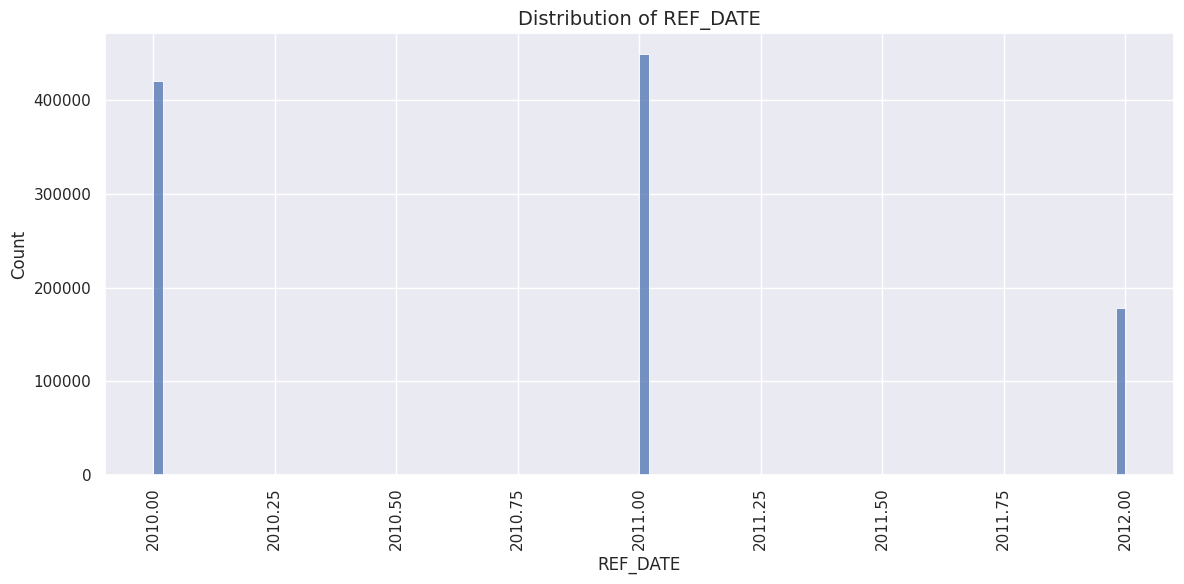

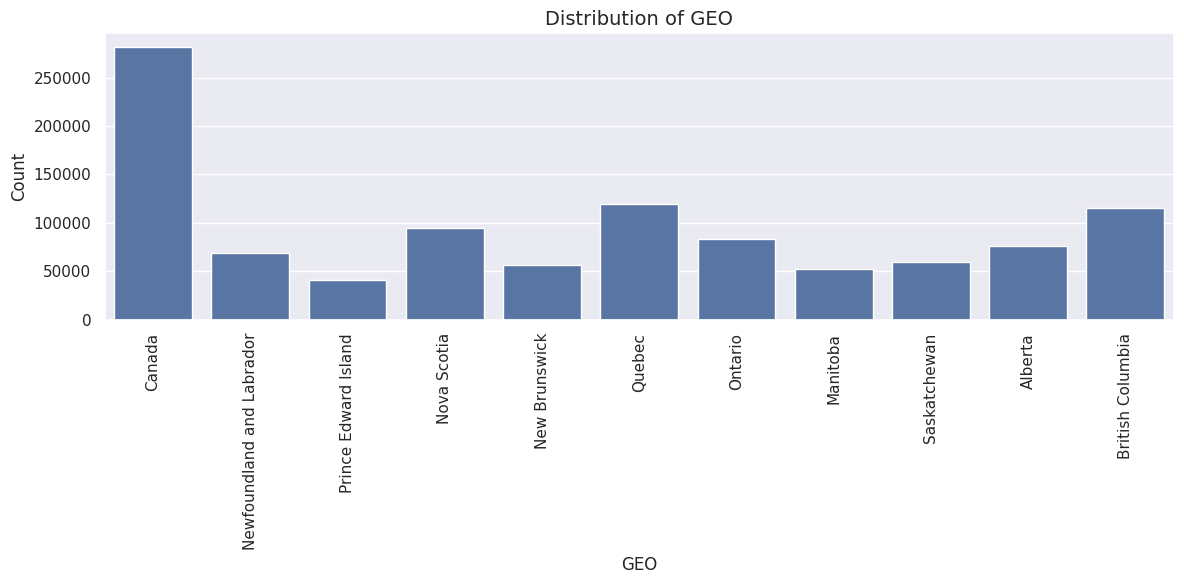

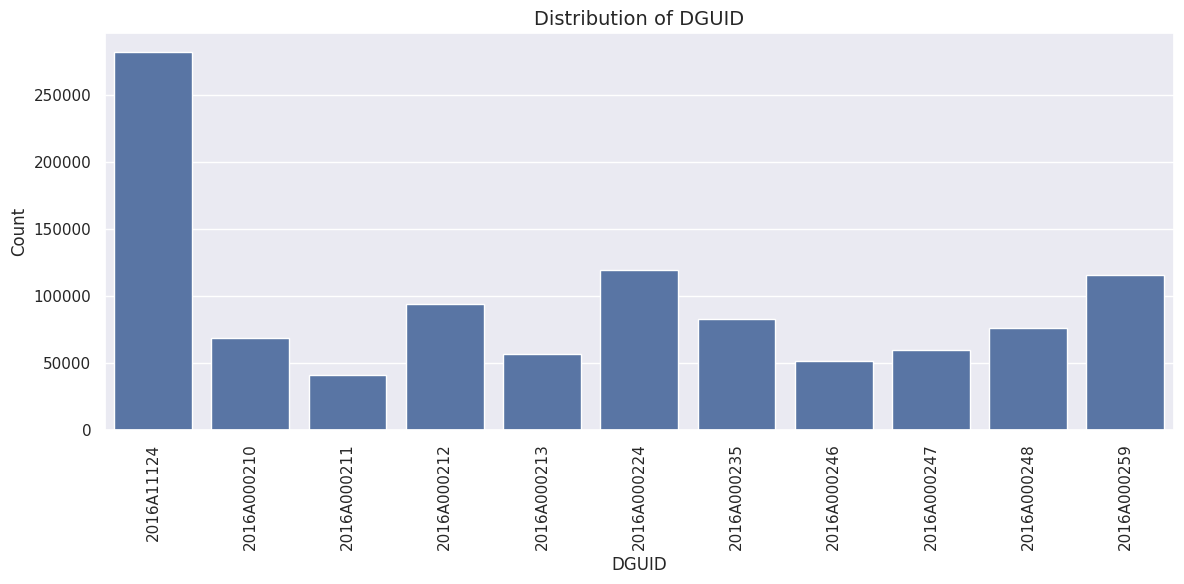

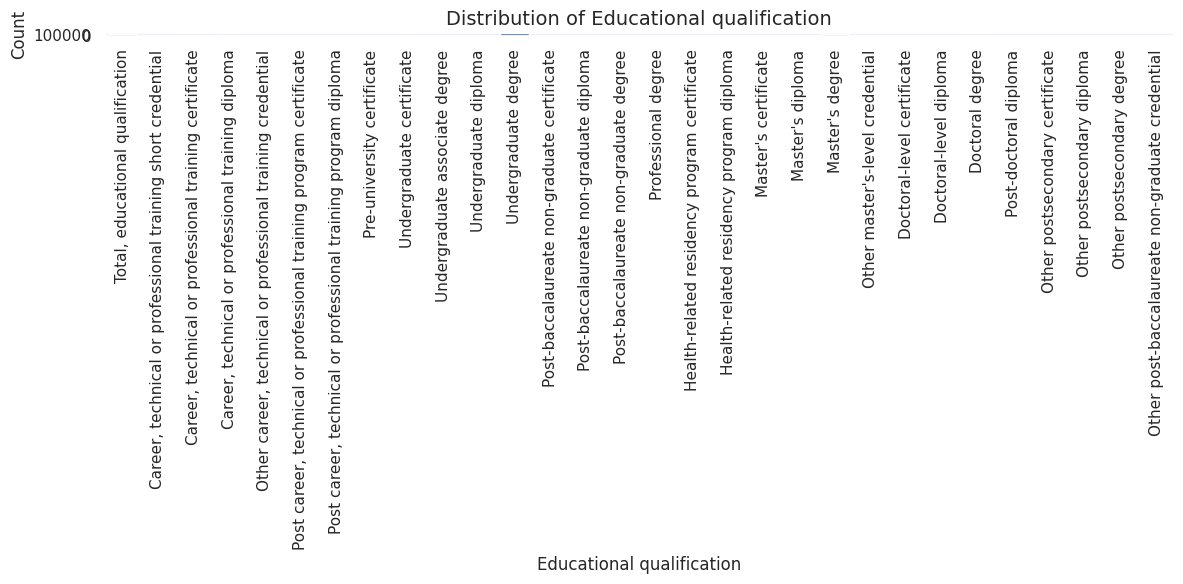

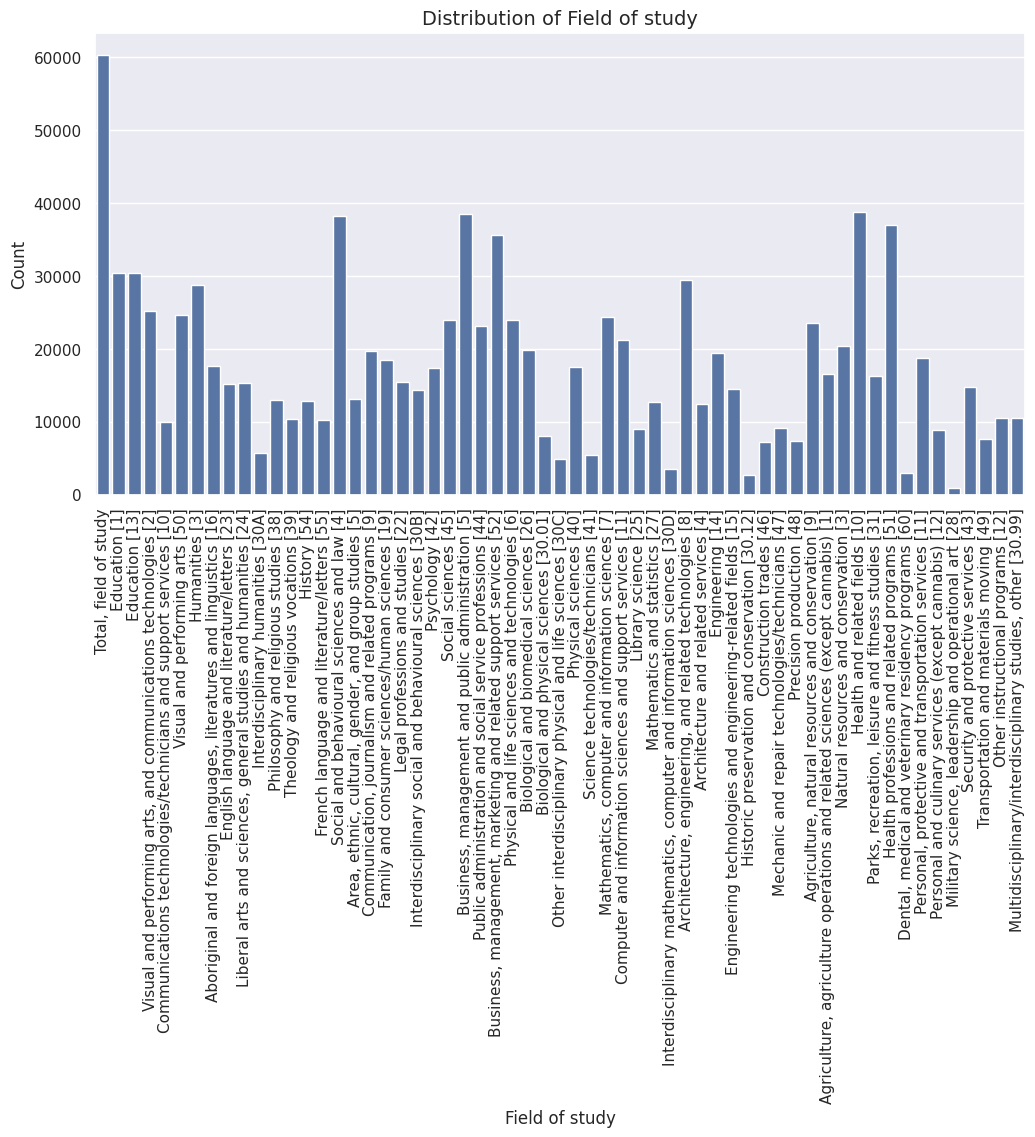

In [16]:
# Select a subset of columns for plotting (adjust as needed based on dataset)
columns_to_plot = df_clean.select_dtypes(include=['int64', 'float64', 'object']).columns[:5]

# Plot the distributions for the selected columns
plot_distributions_one_by_one(df, columns_to_plot)

In [17]:
df_clean.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Educational qualification',
       'Field of study', 'Gender', 'Age group', 'Status of student in Canada',
       'Characteristics after graduation', 'Graduate statistics', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

## 4. Exploratory Data Analysis

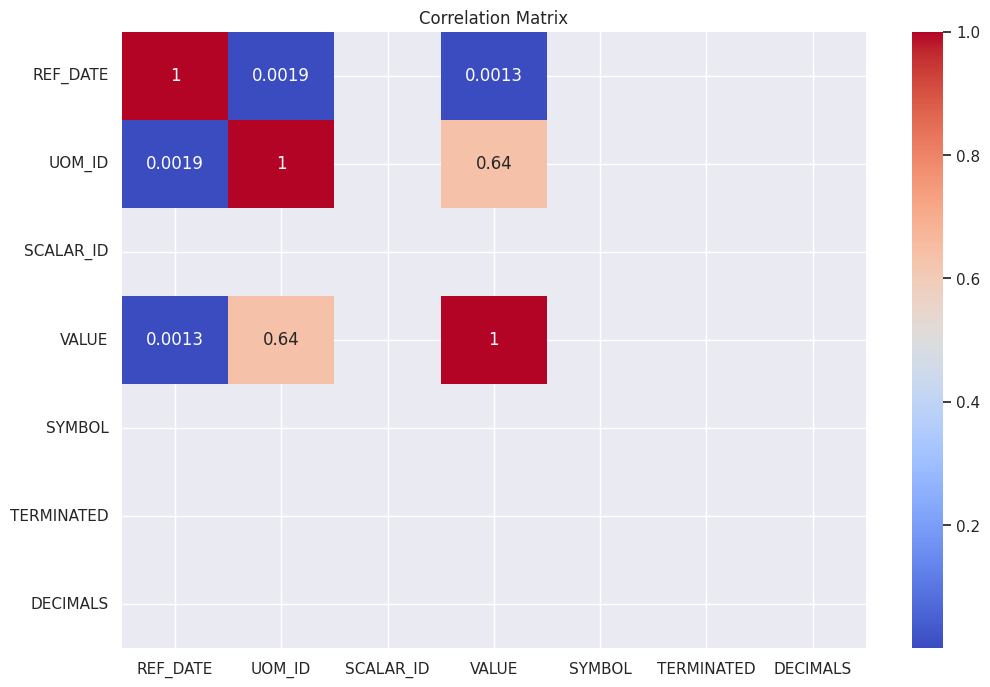

In [19]:
# Correlation analysis
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 5. Time Series Analysis

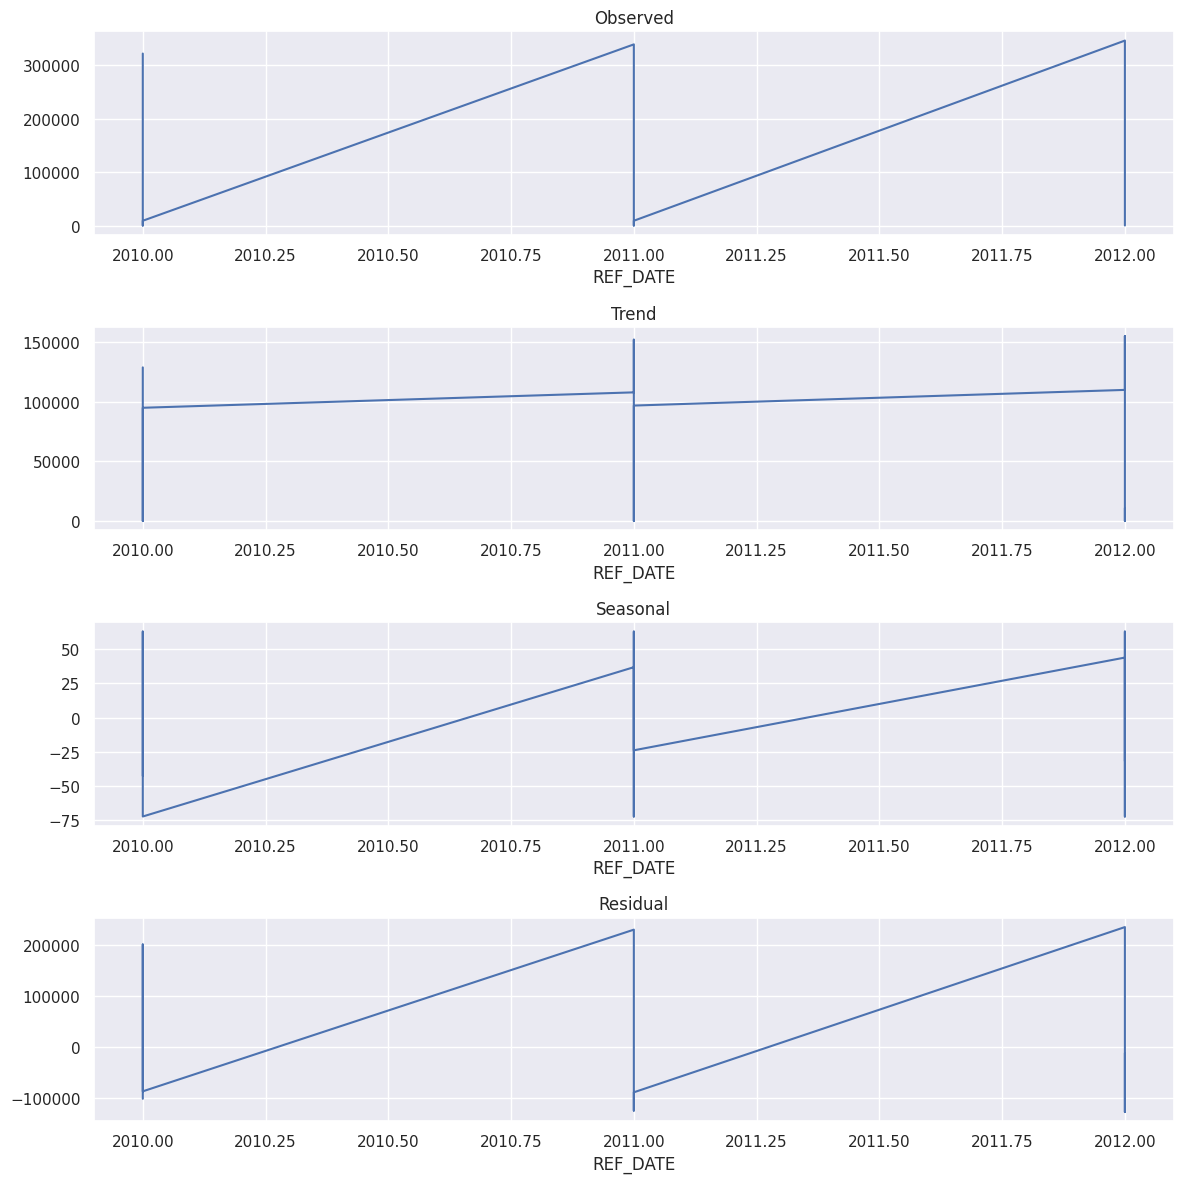

In [20]:
# Perform time series analysis
perform_time_series_analysis(df_clean, 'REF_DATE', 'VALUE')  # Analyze graduation trends over time

## 6. Dimensionality Reduction and Clustering

In [ ]:
# Perform clustering analysis
clusters = perform_clustering(df_clean[df_clean['Gender'] != 'Both sexes'], ['REF_DATE', 'VALUE'])  # Cluster analysis by year and graduate numbers

## 7. Machine Learning Models

In [ ]:
# Prepare features and target
X = df_clean[['feature1', 'feature2', 'feature3']]  # Replace with actual features
y = df_clean['target']  # Replace with actual target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and parameter grids
models = {
    'random_forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20]
    }),
    'decision_tree': (DecisionTreeClassifier(), {
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    }),
    'logistic_regression': (LogisticRegression(), {
        'C': [0.1, 1.0],
        'penalty': ['l1', 'l2']
    })
}

# Train and evaluate models
results = {}
for name, (model, params) in models.items():
    best_model, metrics = train_evaluate_model(X_train, X_test, y_train, y_test, model, params)
    results[name] = {'model': best_model, 'metrics': metrics}

# Compare models
for name, result in results.items():
    print(f"\n{name.upper()} RESULTS:")
    for metric, value in result['metrics'].items():
        print(f"{metric}: {value:.4f}")

## 8. Model Deployment

In [ ]:
# Select best model based on metrics
best_model_name = max(results.items(), key=lambda x: x[1]['metrics']['accuracy'])[0]
best_model = results[best_model_name]['model']

# Save model
joblib.dump(best_model, 'best_model.joblib')

# Demonstrate model loading and prediction
loaded_model = joblib.load('best_model.joblib')
sample_prediction = loaded_model.predict(X_test.head(1))
print("\nSample Prediction:", sample_prediction)